### First, we will collect the last 500 issues (opened and closed) and store them in a dataframe

In [1]:
import requests
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from wordcloud import WordCloud
from matplotlib.dates import DateFormatter, DayLocator, HourLocator

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Extracting issues informations

In [51]:
def get_last_n_issues(repo_owner, repo_name, n=500):
    base_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/issues"
    per_page = 100  # Maximum number of issues per page
    num_pages = (n - 1) // per_page + 1

    all_issues = []

    for page in range(1, num_pages + 1):
        params = {
            'state': 'all',
            'per_page': per_page,
            'page': page,
        }

        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            issues = response.json()
            all_issues.extend(issues)
        else:
            print(f"Error fetching issues. Status code: {response.status_code}")
            return None

    return all_issues[:n]  # Return only n issues

def create_dataframe(issues):
    if issues:
        # Extract relevant information from each issue
        data = {
            'number': [issue['number'] for issue in issues],
            'title': [issue['title'] for issue in issues],
            'state': [issue['state'] for issue in issues],
            'created at': [issue['created_at'] for issue in issues],
            'closed at': [issue['closed_at'] if 'closed_at' in issue else None for issue in issues],
            'user': [issue['user']['login'] for issue in issues],
            'labels': [issue['labels'] for issue in issues],
            'description': [issue['body'] if 'body' in issue else None for issue in issues],
        }

        # Create a DataFrame from the extracted data
        df = pd.DataFrame(data)
        return df
    else:
        return None

repo_owner = 'rails'
repo_name = 'rails'
issues = get_last_n_issues(repo_owner, repo_name)

if issues:
    df = create_dataframe(issues)
else:
    print("Failed to fetch issues.")

In [52]:
df.head()

,number,title,state,created at,closed at,user,labels,description
0,50925,Upgrading Rails 7.0.8 to 7.1.3 broke ActionTex...,closed,2024-01-30T13:37:50Z,2024-01-30T13:38:01Z,airblade,[],"After upgrading from 7.0.8 to 7.1.3, images th..."
1,50924,`ActiveStorage::Analyzer::VideoAnalyzerTest#te...,open,2024-01-30T13:22:24Z,None,yahonda,"[{'id': 664533972, 'node_id': 'MDU6TGFiZWw2NjQ...",Managed to reproduce https://buildkite.com/rai...
2,50923,BacktraceCleaner silence core internal methods...,closed,2024-01-30T12:26:31Z,2024-01-30T12:42:24Z,casperisfine,"[{'id': 107194, 'node_id': 'MDU6TGFiZWwxMDcxOT...",Ref: https://bugs.ruby-lang.org/issues/20227\r...
3,50922,Fix loading schema cache when all databases ha...,open,2024-01-30T11:49:46Z,None,fatkodima,"[{'id': 107191, 'node_id': 'MDU6TGFiZWwxMDcxOT...",Fixes #50910.
4,50921,Require 'uri' explicitly to address `NameError...,open,2024-01-30T11:33:51Z,None,yahonda,"[{'id': 107194, 'node_id': 'MDU6TGFiZWwxMDcxOT...",### Motivation / Background\r\n\r\nThis commit...


In [53]:
df.iloc[90]['description']

"\r\nEvery time I have a runtime error running either the rails server or tests my error logs include a massive stack trace that I haven't been able to silence.\r\n\r\n[Gist of example development.log](https://gist.github.com/bcowell/b48ab2e820f474e3130e8bd2f3f6c140)\r\n\r\n### Steps to reproduce\r\n1. Run `rails s`\r\n2. Edit any line in a method to have invalid ruby\r\n3. Save the file and execute so it runs the method/test\r\n> My console fills with the massive stack trace\r\n\r\n### Expected behavior\r\nI expect an error message to include a reasonable stack trace with a few lines.\r\n\r\n### Actual behavior\r\nStack trace on every error is roughly 10k lines...\r\n\r\n### System configuration\r\nMacBook Pro 2019 Intel \r\nmacOS 13.3.1\r\n\r\n**Rails version**:\r\n6.1.7.6\r\n**Ruby version**:\r\n5.0.2"

## Preprocess Dataset

In [54]:
def extract_label_names(labels):
    if labels is not None:
        return [label['name'] for label in labels]
    else:
        return None

def remove_comments(text):
    return re.sub(r'<!--(.*?)-->', '', text, flags=re.DOTALL)

def remove_markdown(markdown):
    # Replace bold and italicized text with plain text
    markdown = re.sub(r'\*\*(.+?)\*\*|__(.+?)__', '', markdown)
    markdown = re.sub(r'_([^_]+)_|\*([^*]+)\*', '', markdown)

    # Replace strikethrough text with plain text
    markdown = re.sub(r'~~(.+?)~~', '', markdown)

    # Replace inline code blocks with plain text
    markdown = re.sub(r'`(.+?)`', '', markdown)

    # Replace code blocks with plain text
    markdown = re.sub(r'```[\s\S]*?```', '', markdown, flags=re.MULTILINE)

    # Remove links
    markdown = re.sub(r'\[([^\]]+?)\]\([^)]+?\)', '', markdown)

    # Remove images
    markdown = re.sub(r'!\[([^\]]+?)\]\([^)]+?\)', '', markdown)

    # Remove headings
    markdown = re.sub(r'^#+\s+(.+?)\s*$', '', markdown, flags=re.MULTILINE)
    markdown = re.sub(r'^\s*=+\s*$', '', markdown, flags=re.MULTILINE)
    markdown = re.sub(r'^\s*-+\s*$', '', markdown, flags=re.MULTILINE)

    # Remove blockquotes
    markdown = re.sub(r'^\s*>\s+(.+?)\s*$', '', markdown, flags=re.MULTILINE)

    # Remove lists
    markdown = re.sub(r'^\s*[\*\+-]\s+(.+?)\s*$', '', markdown, flags=re.MULTILINE)
    markdown = re.sub(r'^\s*\d+\.\s+(.+?)\s*$', '', markdown, flags=re.MULTILINE)

    # Remove horizontal lines
    markdown = re.sub(r'^\s*[-*_]{3,}\s*$', '', markdown, flags=re.MULTILINE)

    # Remove newline characters
    markdown = re.sub(r'[\n\r]+', ' ', markdown)

    return markdown

In [55]:
def preprocess_dataset(df):
    # Handle missing values
    df = df.fillna({'closed at': pd.NaT, 'description': ''})

    # Convert date columns to datetime
    df['created at'] = pd.to_datetime(df['created at'])
    df['closed at'] = pd.to_datetime(df['closed at'])

    # Extract additional features
    df['day of week'] = df['created at'].dt.dayofweek
    df['month'] = df['created at'].dt.month
    df['year'] = df['created at'].dt.year

    # Handle Labels
    df['labels'] = df['labels'].apply(extract_label_names)

    # Text preprocessing for descriptions
    df['description'] = df['description'].apply(remove_comments)
    df['description'] = df['description'].apply(remove_markdown)

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    df['description'] = df['description'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x.lower()) if word.isalnum() and word not in stop_words]))

    # Explore data distributions
    print(df.describe())

    return df

In [56]:
processed_df = preprocess_dataset(df)

             number  day of week      month         year
count    500.000000   500.000000  500.00000   500.000000
mean   50670.660000     2.704000    3.04600  2023.814000
std      145.834165     1.898313    4.28446     0.389496
min    50415.000000     0.000000    1.00000  2023.000000
25%    50545.750000     1.000000    1.00000  2024.000000
50%    50670.500000     3.000000    1.00000  2024.000000
75%    50796.250000     4.000000    1.00000  2024.000000
max    50925.000000     6.000000   12.00000  2024.000000


In [57]:
processed_df.tail(10)

,number,title,state,created at,closed at,user,labels,description,day of week,month,year
490,50425,Remove unused argument in .db_configs_with_ver...,closed,2023-12-21 21:48:50+00:00,2023-12-21 22:23:24+00:00,wildmaples,[activerecord],remov method argument submit pr make sure foll...,3,12,2023
491,50424,Add `explain` support for calculation methods ...,closed,2023-12-21 19:56:56+00:00,2023-12-29 15:14:33+00:00,p8,[activerecord],allow take oper column name argument rubi coun...,3,12,2023
492,50423,Link to query assertions in testing guide [ci-...,closed,2023-12-21 17:03:39+00:00,2023-12-27 22:34:01+00:00,p8,[docs],link recent ad queri edg guid edg api doc read...,3,12,2023
493,50422,Include view tests in rake stats,closed,2023-12-21 16:47:06+00:00,2024-01-01 17:53:26+00:00,nhorton,[railties],view test ad rail directori contain ad list di...,3,12,2023
494,50421,Using `:destroy_async` with `has_many` causes ...,closed,2023-12-21 15:53:45+00:00,2023-12-21 21:54:48+00:00,ZempTime,[],rubi requir gemfil true sourc http gitrecord r...,3,12,2023
495,50420,Doc: Prevent `Attributes` to be a link [ci-ski...,closed,2023-12-21 15:52:43+00:00,2023-12-21 15:53:23+00:00,p8,[activerecord],,3,12,2023
496,50419,Doc: Prevent `Attributes` to be a link [ci-skip],closed,2023-12-21 15:38:53+00:00,2023-12-21 15:51:20+00:00,okuramasafumi,[activerecord],http link http correct pull request prevent li...,3,12,2023
497,50418,Use buffered read while generating Blob checks...,closed,2023-12-21 14:54:58+00:00,2023-12-26 18:38:17+00:00,the-spectator,[activestorage],debug memori issu app notic larg amount string...,3,12,2023
498,50417,Add `to_sql` support for calculation methods l...,open,2023-12-21 10:53:01+00:00,NaT,p8,[activerecord],calcul method directli return result possibl c...,3,12,2023
499,50415,I want to optimize rake commands on CI,closed,2023-12-21 06:25:39+00:00,2023-12-21 06:53:53+00:00,alpaca-tc,[],default rail configur run eagerload effect run...,3,12,2023


In [58]:
processed_df.iloc[90]['description']

'everi time runtim error run either rail server test error log includ massiv stack trace abl silenc expect error messag includ reason stack trace line stack trace everi error roughli 10k line macbook pro 2019 intel maco'

In [59]:
processed_df.iloc[90]['labels']

[]

### Export dataset

In [36]:
processed_df.to_csv('rails_issues.csv', index=False)

### Import dataset

In [2]:
processed_df = pd.read_csv('/content/rails_issues.csv')

processed_df['created at'] = pd.to_datetime(processed_df['created at'])
processed_df['closed at'] = pd.to_datetime(processed_df['closed at'])
processed_df['labels'] = processed_df['labels'].apply(literal_eval)

## General Overview

In [104]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   number       500 non-null    int64              
 1   title        500 non-null    object             
 2   state        500 non-null    object             
 3   created at   500 non-null    datetime64[ns, UTC]
 4   closed at    376 non-null    datetime64[ns, UTC]
 5   user         500 non-null    object             
 6   labels       500 non-null    object             
 7   description  491 non-null    object             
 8   day of week  500 non-null    int64              
 9   month        500 non-null    int64              
 10  year         500 non-null    int64              
dtypes: datetime64[ns, UTC](2), int64(4), object(5)
memory usage: 43.1+ KB


In [113]:
processed_df.iloc[3]['labels']

['activerecord', 'railties']

In [106]:
# Number of rows that don't have any labels
empty_labels_count = processed_df[processed_df['labels'].apply(lambda x: len(x) == 0)].shape[0]

print(f"Number of rows with empty labels: {empty_labels_count}")

Number of rows with empty labels: 87


In [107]:
# Number of rows that have many labels
more_than_one_label_count = processed_df[processed_df['labels'].apply(lambda x: len(x) > 1)].shape[0]

print(f"Number of rows with more than one label: {more_than_one_label_count}")

Number of rows with more than one label: 101


In [23]:
unique_labels = pd.unique(processed_df['labels'].explode().dropna())

print("Number of Unique Labels:")
print(len(unique_labels))

Number of Unique Labels:
20


In [115]:
unique_labels

array(['activestorage', 'ci issues', 'activesupport', 'activerecord',
       'railties', 'actionmailer', 'actionpack', 'actionmailbox',
       'actiontext', 'docs', 'attached PR', 'actionview', 'activemodel',
       'activejob', 'actioncable', 'With reproduction steps',
       'more-information-needed', 'needs backport', 'regression',
       'good first issue'], dtype=object)

In [127]:
max_labels_length = processed_df['labels'].apply(len).max()

print(f"Maximum length of labels array: {max_labels_length}")

Maximum length of labels array: 13


In [130]:
row_with_max_labels = processed_df[processed_df['labels'].apply(len) == max_labels_length]

print("Row with the maximum length of labels:")
row_with_max_labels['labels']

Row with the maximum length of labels:


429    [actionmailer, actionpack, activemodel, active...
Name: labels, dtype: object

In [63]:
# Periode of creation of the issues
first_date = processed_df['created at'].min()
last_date = processed_df['created at'].max()

print(f"First Date: {first_date}")
print(f"Last Date: {last_date}")

First Date: 2023-12-21 06:25:39+00:00
Last Date: 2024-01-30 13:37:50+00:00


In [64]:
days_difference = (last_date - first_date).days

print(f"Number of days between the two dates: {days_difference} days")

Number of days between the two dates: 40 days


In [65]:
# Number of users
num_users = processed_df['user'].nunique()

print(f"Number of unique users who created issues: {num_users}")

Number of unique users who created issues: 196


In [68]:
empty_description_count = processed_df[processed_df['description'].apply(lambda x: not(x))].shape[0]

print(f"Number of rows with empty or null 'Description': {empty_description_count}")

Number of rows with empty or null 'Description': 9


In [69]:
rows_with_empty_description = processed_df[processed_df['description'].apply(lambda x: not(x))]

# Print the DataFrame with relevant columns
print("DataFrame with rows where 'Description' is empty or null:")
rows_with_empty_description

DataFrame with rows where 'Description' is empty or null:


,number,title,state,created at,closed at,user,labels,description,day of week,month,year
184,50736,Add examples to #slice and #values_at document...,closed,2024-01-12 19:53:51+00:00,2024-01-12 19:53:58+00:00,p8,"[activemodel, activerecord]",,4,1,2024
227,50693,Merge pull request #50682 from p8/activerecord...,closed,2024-01-10 09:29:22+00:00,2024-01-10 09:29:39+00:00,p8,"[activerecord, docs]",,2,1,2024
228,50692,Document `Calculations#count` and `Calculation...,closed,2024-01-10 09:27:43+00:00,2024-01-10 09:27:57+00:00,p8,[activerecord],,2,1,2024
268,50652,Merge pull request #50595 from p8/guides/api-d...,closed,2024-01-08 18:14:40+00:00,2024-01-08 18:14:56+00:00,p8,[docs],,0,1,2024
269,50651,Merge pull request #50592 from p8/guides/expan...,closed,2024-01-08 18:12:30+00:00,2024-01-08 18:12:52+00:00,p8,[docs],,0,1,2024
285,50635,Minor improvements to Connection Pool docs,closed,2024-01-08 00:00:11+00:00,2024-01-08 08:56:49+00:00,ghiculescu,"[activerecord, docs]",,0,1,2024
371,50549,Backport 1ea796d6a8,closed,2024-01-03 07:19:18+00:00,2024-01-03 07:20:21+00:00,p8,"[actionmailer, actionpack, actioncable, action...",,2,1,2024
422,50498,Document Cache::WriteOptions [ci-skip],closed,2023-12-31 05:37:49+00:00,2023-12-31 05:45:26+00:00,skipkayhil,[activesupport],,6,12,2023
495,50420,Doc: Prevent `Attributes` to be a link [ci-ski...,closed,2023-12-21 15:52:43+00:00,2023-12-21 15:53:23+00:00,p8,[activerecord],,3,12,2023


### Deeper Exploratory Analysis

In [122]:
# Closing rate of no-label issues
total_no_label_issues = processed_df[processed_df['labels'].apply(len) == 0].shape[0]
closed_no_label_issues = processed_df[(processed_df['labels'].apply(len) == 0) & (processed_df['state'] == 'closed')].shape[0]

closing_rate_no_label = closed_no_label_issues / total_no_label_issues if total_no_label_issues > 0 else 0

print(f"Closing rate of issues with no labels: {closing_rate_no_label:.2%}")

Closing rate of issues with no labels: 81.61%


In [123]:
# Closing rate of single-label issues
total_single_label_issues = processed_df[processed_df['labels'].apply(len) == 1].shape[0]
closed_single_label_issues = processed_df[(processed_df['labels'].apply(len) == 1) & (processed_df['state'] == 'closed')].shape[0]

closing_rate_single_label = closed_single_label_issues / total_single_label_issues if total_single_label_issues > 0 else 0

print(f"Closing rate of issues with single labels: {closing_rate_single_label:.2%}")

Closing rate of issues with single labels: 73.72%


In [125]:
# Closing rate of multi-labels issues
total_multi_labels_issues = processed_df[processed_df['labels'].apply(len) > 1].shape[0]
closed_multi_labels_issues = processed_df[(processed_df['labels'].apply(len) > 1) & (processed_df['state'] == 'closed')].shape[0]

closing_rate_multi_labels = closed_multi_labels_issues / total_multi_labels_issues if total_multi_labels_issues > 0 else 0

print(f"Closing rate of issues with multi-labels: {closing_rate_multi_labels:.2%}")

Closing rate of issues with multi-labels: 74.26%


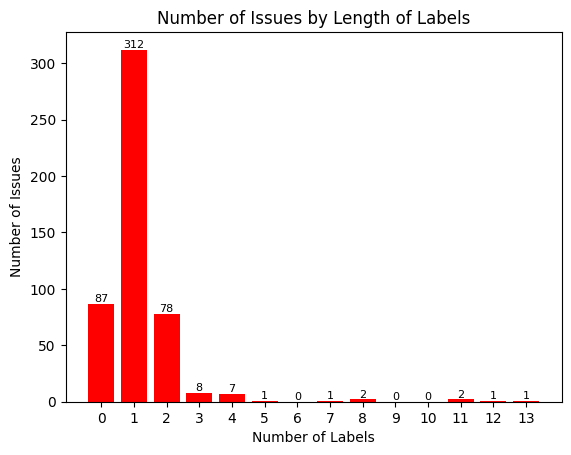

In [142]:
max_labels_length = 13

# Calculate the number of issues for each length of labels, including zero counts
labels_length_counts = processed_df['labels'].apply(len).value_counts().reindex(range(0, max_labels_length + 1), fill_value=0)

# Plotting
plt.bar(labels_length_counts.index, labels_length_counts.values, color='red')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Issues')
plt.title('Number of Issues by Length of Labels')
plt.xticks(range(0, max_labels_length + 1))  # Set x-axis ticks for each possible length of labels

# Show the number on top of each bar
for i, value in enumerate(labels_length_counts.values):
    plt.text(i , value + 0.1, str(value), ha='center', va='bottom', fontsize=8)

plt.show()

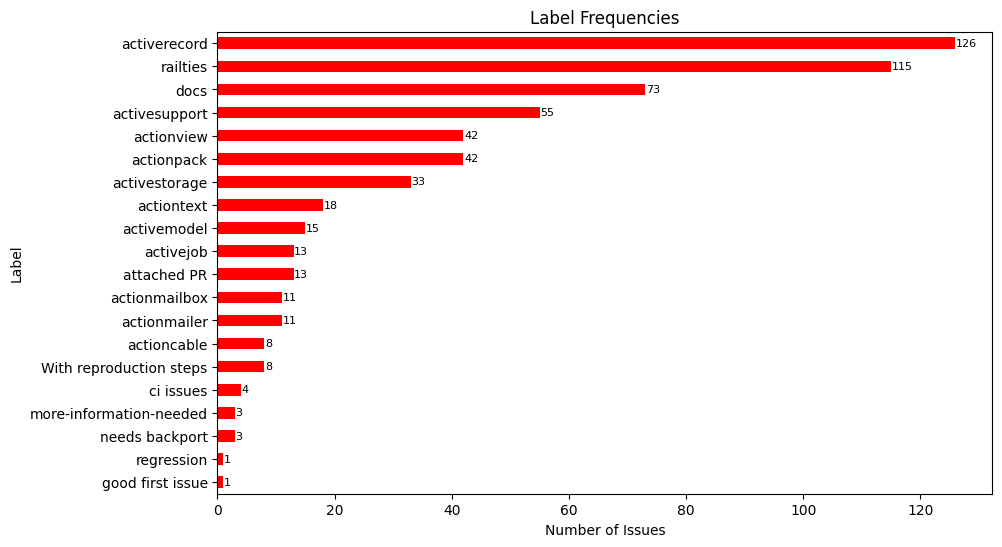

In [146]:
label_counts = processed_df['labels'].explode().value_counts()

# Plotting a horizontal bar plot with numbers next to each bar
plt.figure(figsize=(10, 6))
ax = label_counts.sort_values().plot(kind='barh', color='red')
plt.xlabel('Number of Issues')
plt.ylabel('Label')
plt.title('Label Frequencies')

# Add numbers next to each bar
for i, value in enumerate(label_counts.sort_values()):
    ax.text(value + 0.1, i, str(value), ha='left', va='center', fontsize=8)

plt.show()

In [157]:
import plotly.express as px

# Assuming label_counts is a Series with label frequencies
label_counts = processed_df['labels'].explode().value_counts()

# Create a DataFrame from the label counts
df = pd.DataFrame({'Label': label_counts.index, 'Frequency': label_counts.values})

# Create and display the treemap
fig = px.treemap(df, path=['Label'], values='Frequency', title='Label Frequencies Treemap')
fig.show()

In [161]:
single_label_rows = processed_df[processed_df['labels'].apply(len) == 1]

# Extract unique labels from the selected rows
unique_single_labels = set(single_label_rows['labels'].explode())

# Display the list of unique labels used only once
print("Unique Labels used in single-lable issues:", list(unique_single_labels))

Unique Labels used only once: ['activesupport', 'actiontext', 'docs', 'actionmailbox', 'actionmailer', 'attached PR', 'activerecord', 'actioncable', 'actionpack', 'railties', 'activemodel', 'activejob', 'activestorage', 'more-information-needed', 'actionview']


In [162]:
len(unique_single_labels)

15

In [166]:
list(unique_single_labels)


['activesupport',
 'actiontext',
 'docs',
 'actionmailbox',
 'actionmailer',
 'attached PR',
 'activerecord',
 'actioncable',
 'actionpack',
 'railties',
 'activemodel',
 'activejob',
 'activestorage',
 'more-information-needed',
 'actionview']

In [168]:
unique_labels = pd.unique(processed_df['labels'].explode().dropna())

multiple_labels = [element for element in unique_labels if element not in unique_single_labels]
len(multiple_labels)

5

In [169]:
multiple_labels

['ci issues',
 'With reproduction steps',
 'needs backport',
 'regression',
 'good first issue']

### Label co-occurence Analysis

In [31]:
from itertools import combinations

# Filter rows with more than one label (excluding rows with one or no labels)
multi_label_rows = processed_df[processed_df['labels'].apply(lambda x: len(x) > 1)]

# Create a new DataFrame to store the results
label_cooccurrence_counts = pd.DataFrame(index=unique_labels, columns=unique_labels).fillna(0)

# Iterate through rows and update co-occurrence counts
for labels_row in multi_label_rows['labels']:
    label_combinations = combinations(labels_row, 2)  # Get all unique pairs of labels
    for label1, label2 in label_combinations:
        if label1 in unique_labels and label2 in unique_labels:
            label_cooccurrence_counts.at[label1, label2] += 1
            label_cooccurrence_counts.at[label2, label1] += 1  # Include both directions

# Display the resulting DataFrame
print("Label Co-occurrence Counts in Multi-Label Issues:")
print(label_cooccurrence_counts)

Label Co-occurrence Counts in Multi-Label Issues:
                         activestorage  ci issues  activesupport  \
activestorage                        0          1              5   
ci issues                            1          0              0   
activesupport                        5          0              0   
activerecord                         6          2             11   
railties                             9          0             11   
actionmailer                         4          0              7   
actionpack                           4          0             11   
actionmailbox                        6          0              4   
actiontext                           7          0              4   
docs                                 2          0              2   
attached PR                          3          0              0   
actionview                           5          1             11   
activemodel                          5          0              9  

In [32]:
from itertools import combinations

# Assuming label_cooccurrence_counts is your DataFrame with co-occurrence counts

# Calculate total occurrences for each label
total_occurrences = label_cooccurrence_counts.sum(axis=1)

# Create a new DataFrame to store the percentage results
label_cooccurrence_percentages = label_cooccurrence_counts.copy()

# Calculate percentages for each cell
for label in label_cooccurrence_counts.index:
    label_cooccurrence_percentages.loc[label, :] = (label_cooccurrence_counts.loc[label, :] / total_occurrences[label]) * 100

# Display the resulting DataFrame
print("Label Co-occurrence Percentages in Multi-Label Issues:")
print(label_cooccurrence_percentages)

Label Co-occurrence Percentages in Multi-Label Issues:
                         activestorage  ci issues  activesupport  \
activestorage                 0.000000   1.470588       7.352941   
ci issues                    25.000000   0.000000       0.000000   
activesupport                 5.681818   0.000000       0.000000   
activerecord                  5.357143   1.785714       9.821429   
railties                      8.490566   0.000000      10.377358   
actionmailer                  6.250000   0.000000      10.937500   
actionpack                    5.128205   0.000000      14.102564   
actionmailbox                11.111111   0.000000       7.407407   
actiontext                   12.280702   0.000000       7.017544   
docs                          5.128205   0.000000       5.128205   
attached PR                  17.647059   0.000000       0.000000   
actionview                    5.813953   1.162791      12.790698   
activemodel                   7.142857   0.000000      12.857

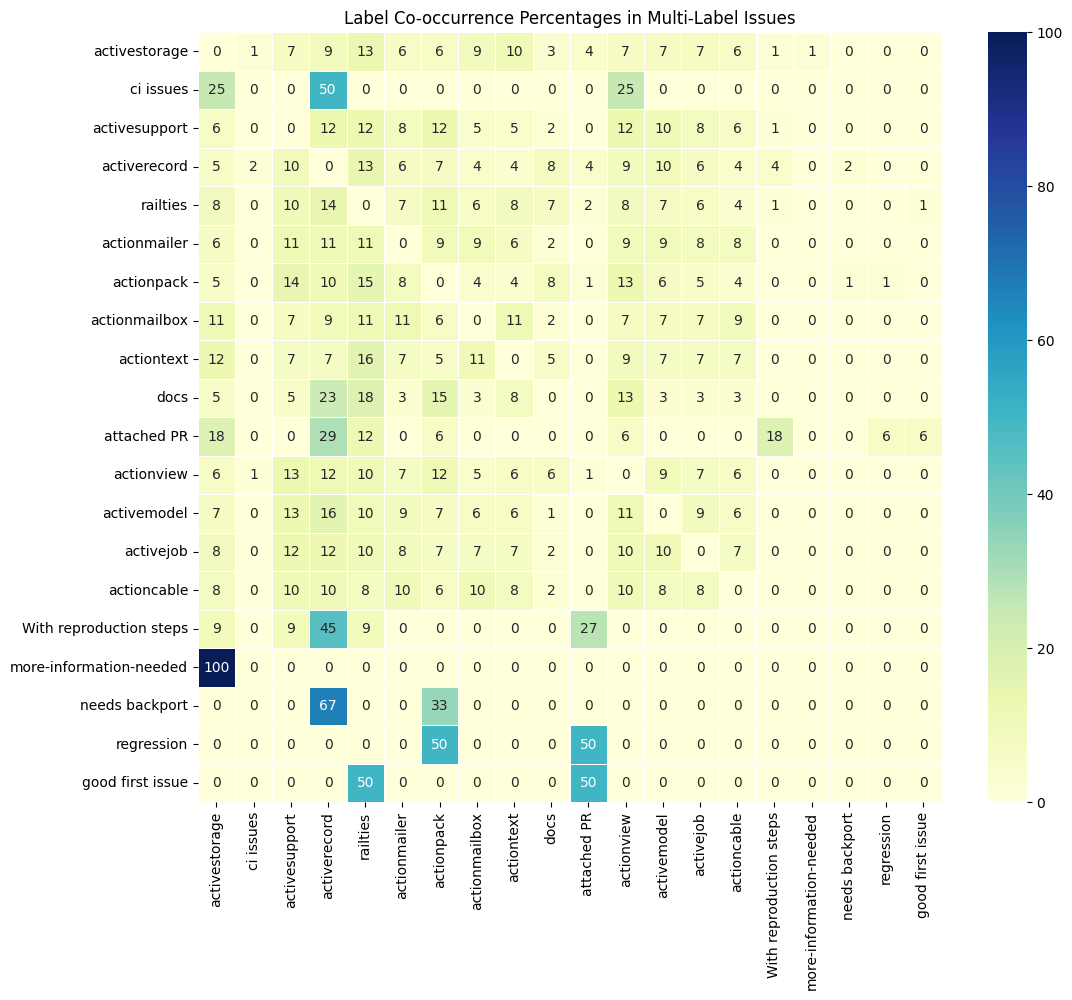

In [34]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(label_cooccurrence_percentages, annot=True, cmap="YlGnBu", fmt=".0f", linewidths=.5)
plt.title("Label Co-occurrence Percentages in Multi-Label Issues")
plt.show()

## Close time distribution of issues

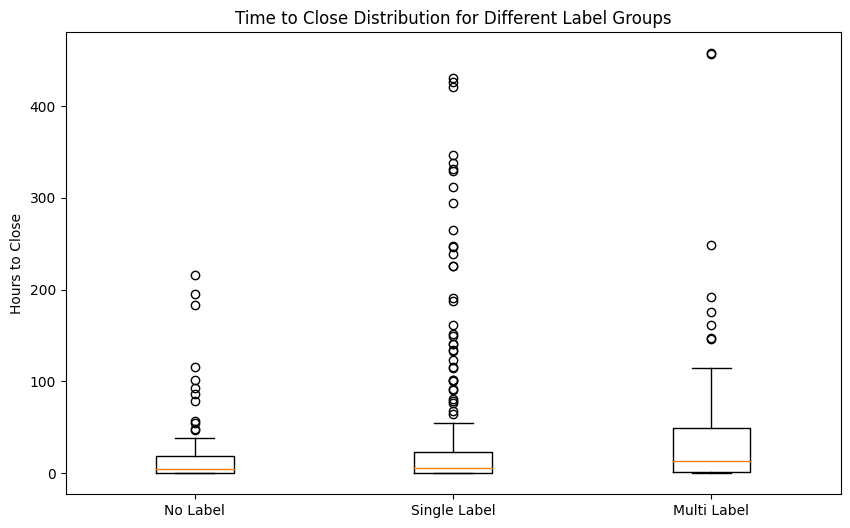

In [43]:
# Calculate time to close in hours for each issue
processed_df['time to close'] = (processed_df['closed at'] - processed_df['created at']).dt.total_seconds() / 3600

# Categorize issues into three groups
no_label_issues = processed_df[(processed_df['labels'].apply(len) == 0) & (processed_df['state'] == 'closed')]
single_label_issues = processed_df[(processed_df['labels'].apply(len) == 1) & (processed_df['state'] == 'closed')]
multi_label_issues = processed_df[(processed_df['labels'].apply(len) > 1) & (processed_df['state'] == 'closed')]

# Plot distribution boxes for the three groups
plt.figure(figsize=(10, 6))
plt.boxplot([
    no_label_issues['time to close'],
    single_label_issues['time to close'],
    multi_label_issues['time to close']
], labels=['No Label', 'Single Label', 'Multi Label'])

plt.title('Time to Close Distribution for Different Label Groups')
plt.ylabel('Hours to Close')
plt.show()

## Issues as time series

### Daily Analysis

In [ ]:
processed_df.set_index('created at', inplace=True)

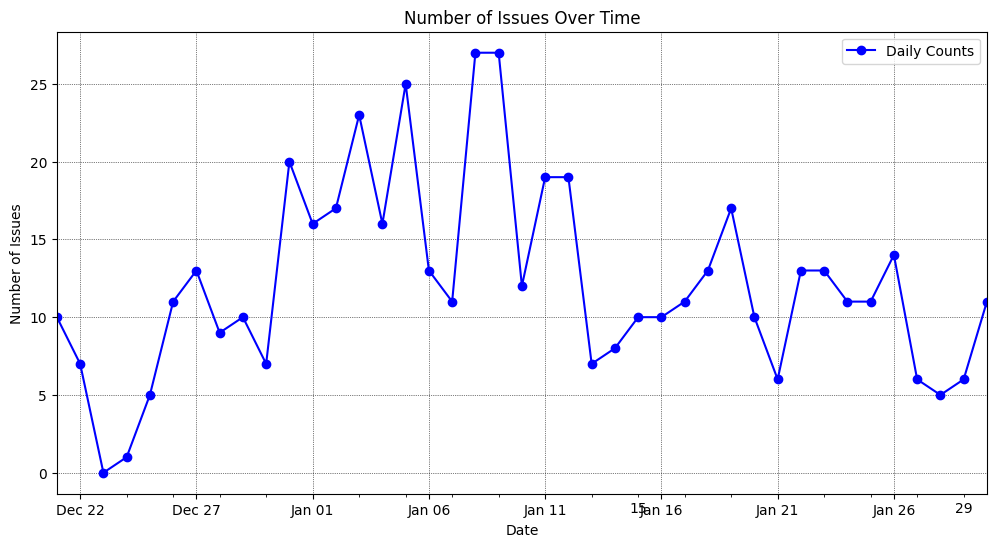

In [97]:
# Resample the time series data to daily frequency and count the number of issues for each day
daily_counts = processed_df.resample('D').size()

# Plot the time series
fig, ax = plt.subplots(figsize=(12, 6))
daily_counts.plot(style='-o', color='b', label='Daily Counts')

# Customize x-axis ticks to show date every 5 days
ax.xaxis.set_major_locator(DayLocator(interval=5))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

# Add grid lines every 5 hours
ax.xaxis.set_minor_locator(DayLocator(interval=2))
ax.grid(linestyle=':', linewidth='0.5', color='black')

plt.title('Number of Issues Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Issues')
plt.legend()
plt.show()

In [74]:
daily_counts.describe()

count    41.000000
mean     12.195122
std       6.301665
min       0.000000
25%       8.000000
50%      11.000000
75%      16.000000
max      27.000000
dtype: float64

In [75]:
daily_counts

created at
2023-12-21 00:00:00+00:00    10
2023-12-22 00:00:00+00:00     7
2023-12-23 00:00:00+00:00     0
2023-12-24 00:00:00+00:00     1
2023-12-25 00:00:00+00:00     5
2023-12-26 00:00:00+00:00    11
2023-12-27 00:00:00+00:00    13
2023-12-28 00:00:00+00:00     9
2023-12-29 00:00:00+00:00    10
2023-12-30 00:00:00+00:00     7
2023-12-31 00:00:00+00:00    20
2024-01-01 00:00:00+00:00    16
2024-01-02 00:00:00+00:00    17
2024-01-03 00:00:00+00:00    23
2024-01-04 00:00:00+00:00    16
2024-01-05 00:00:00+00:00    25
2024-01-06 00:00:00+00:00    13
2024-01-07 00:00:00+00:00    11
2024-01-08 00:00:00+00:00    27
2024-01-09 00:00:00+00:00    27
2024-01-10 00:00:00+00:00    12
2024-01-11 00:00:00+00:00    19
2024-01-12 00:00:00+00:00    19
2024-01-13 00:00:00+00:00     7
2024-01-14 00:00:00+00:00     8
2024-01-15 00:00:00+00:00    10
2024-01-16 00:00:00+00:00    10
2024-01-17 00:00:00+00:00    11
2024-01-18 00:00:00+00:00    13
2024-01-19 00:00:00+00:00    17
2024-01-20 00:00:00+00:00    

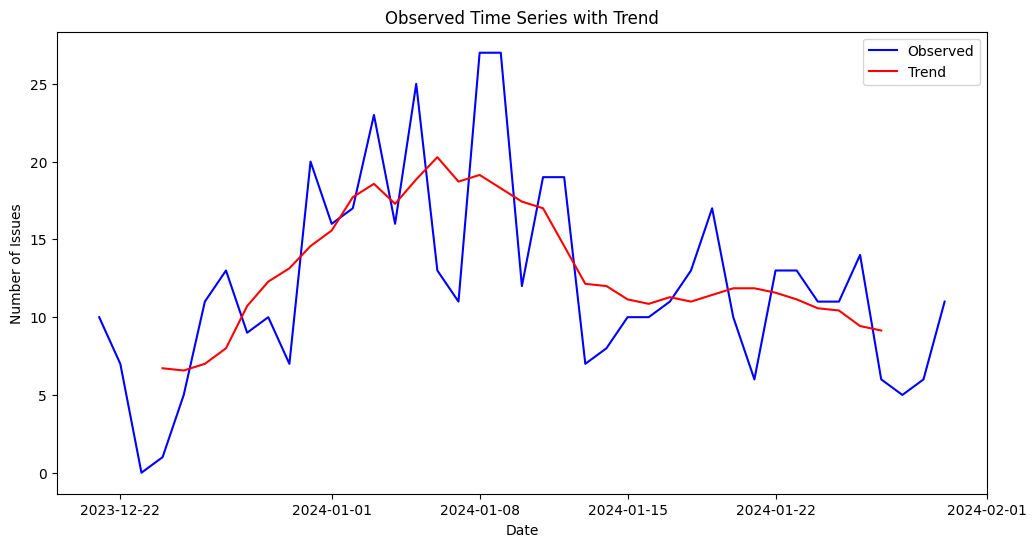

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(daily_counts, model='additive')

# Plot the observed time series along with the trend component
plt.figure(figsize=(12, 6))

plt.plot(result.observed, label='Observed', color='blue')
plt.plot(result.trend, label='Trend', color='red')

plt.title('Observed Time Series with Trend')
plt.xlabel('Date')
plt.ylabel('Number of Issues')
plt.legend()
plt.show()

In [100]:
daily_counts

created at
2023-12-21 00:00:00+00:00    10
2023-12-22 00:00:00+00:00     7
2023-12-23 00:00:00+00:00     0
2023-12-24 00:00:00+00:00     1
2023-12-25 00:00:00+00:00     5
2023-12-26 00:00:00+00:00    11
2023-12-27 00:00:00+00:00    13
2023-12-28 00:00:00+00:00     9
2023-12-29 00:00:00+00:00    10
2023-12-30 00:00:00+00:00     7
2023-12-31 00:00:00+00:00    20
2024-01-01 00:00:00+00:00    16
2024-01-02 00:00:00+00:00    17
2024-01-03 00:00:00+00:00    23
2024-01-04 00:00:00+00:00    16
2024-01-05 00:00:00+00:00    25
2024-01-06 00:00:00+00:00    13
2024-01-07 00:00:00+00:00    11
2024-01-08 00:00:00+00:00    27
2024-01-09 00:00:00+00:00    27
2024-01-10 00:00:00+00:00    12
2024-01-11 00:00:00+00:00    19
2024-01-12 00:00:00+00:00    19
2024-01-13 00:00:00+00:00     7
2024-01-14 00:00:00+00:00     8
2024-01-15 00:00:00+00:00    10
2024-01-16 00:00:00+00:00    10
2024-01-17 00:00:00+00:00    11
2024-01-18 00:00:00+00:00    13
2024-01-19 00:00:00+00:00    17
2024-01-20 00:00:00+00:00    

### Hourly analysis

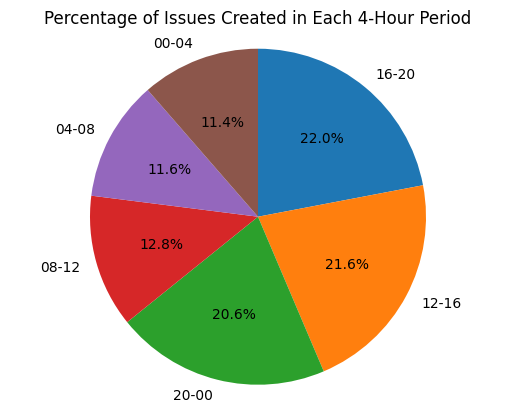

In [95]:
# Create a new column for the period (00-04, 04-08, 08-12, 12-16, 16-20, 20-00)
processed_df['period'] = pd.cut(processed_df.index.hour, bins=[0, 4, 8, 12, 16, 20, 24], labels=['00-04', '04-08', '08-12', '12-16', '16-20', '20-00'], right=False)

# Count the number of issues in each period
period_counts = processed_df['period'].value_counts()

# Plot the pie chart
fig, ax = plt.subplots()
ax.pie(period_counts, labels=period_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Percentage of Issues Created in Each 4-Hour Period')
plt.show()

In [96]:
period_counts

16-20    110
12-16    108
20-00    103
08-12     64
04-08     58
00-04     57
Name: period, dtype: int64

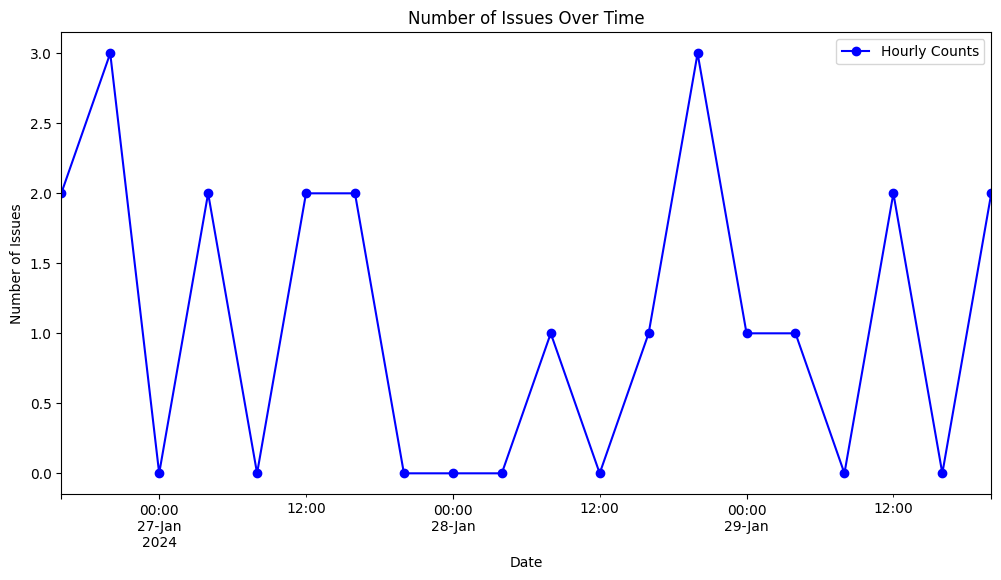

In [92]:
# Resample the time series data to daily frequency and count the number of issues for each hour
hourly_counts = processed_df.resample('4H').size()

# Plot the time series for 3 days (72 points)
fig, ax = plt.subplots(figsize=(12, 6))
hourly_counts[-24:-4].plot(style='-o', color='b', label='Hourly Counts')

plt.title('Number of Issues Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Issues')
plt.legend()
plt.show()

In [93]:
hourly_counts[-24:-4]

created at
2024-01-26 16:00:00+00:00    2
2024-01-26 20:00:00+00:00    3
2024-01-27 00:00:00+00:00    0
2024-01-27 04:00:00+00:00    2
2024-01-27 08:00:00+00:00    0
2024-01-27 12:00:00+00:00    2
2024-01-27 16:00:00+00:00    2
2024-01-27 20:00:00+00:00    0
2024-01-28 00:00:00+00:00    0
2024-01-28 04:00:00+00:00    0
2024-01-28 08:00:00+00:00    1
2024-01-28 12:00:00+00:00    0
2024-01-28 16:00:00+00:00    1
2024-01-28 20:00:00+00:00    3
2024-01-29 00:00:00+00:00    1
2024-01-29 04:00:00+00:00    1
2024-01-29 08:00:00+00:00    0
2024-01-29 12:00:00+00:00    2
2024-01-29 16:00:00+00:00    0
2024-01-29 20:00:00+00:00    2
Freq: 4H, dtype: int64

## User Engagement

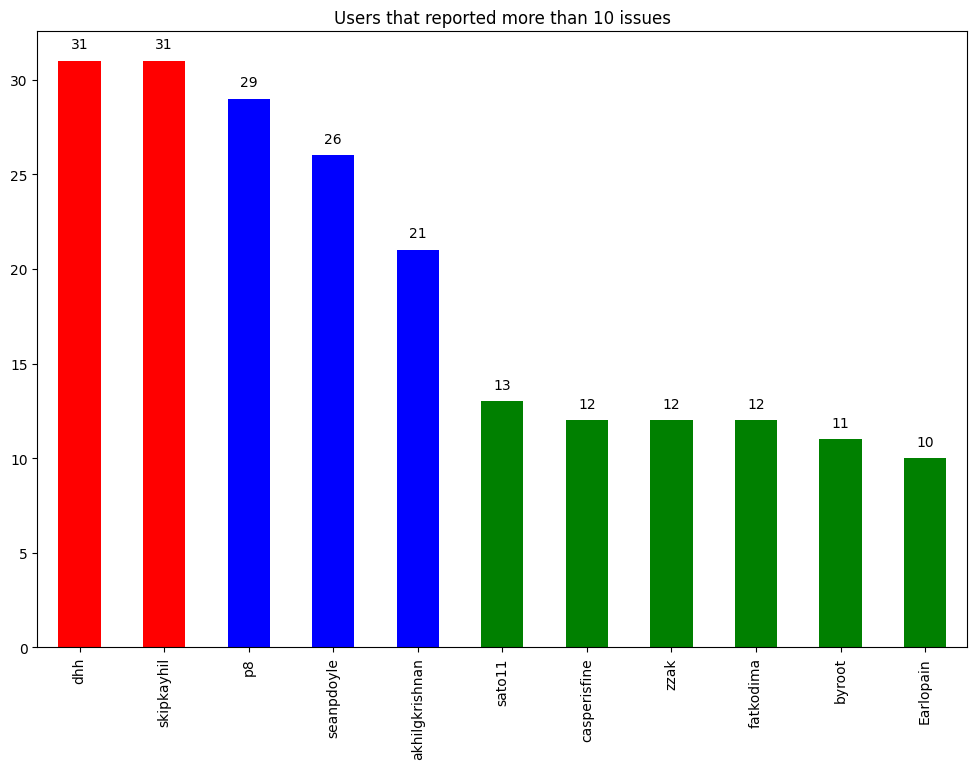

In [116]:
# Analyze user contribution
user_counts = processed_df['user'].value_counts()
# Define the colors based on conditions
colors = ['red' if value >= 30 else 'blue' if 20 <= value < 30 else 'green' for value in user_counts]

# Plot the bar chart
ax = user_counts.head(11).plot(kind='bar', figsize=(12, 8), color=colors, title='Users that reported more than 10 issues')

# Add text annotations for each bar
for i, value in enumerate(user_counts.head(11)):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

In [117]:
user_counts.head(15)

dhh               31
skipkayhil        31
p8                29
seanpdoyle        26
akhilgkrishnan    21
sato11            13
casperisfine      12
zzak              12
fatkodima         12
byroot            11
Earlopain         10
dorianmarie        9
jonathanhefner     8
rafaelfranca       8
bparanj            7
Name: user, dtype: int64

## Issues classification

In [3]:
# Filter the DataFrame to keep only single-label issues
filtered_df = processed_df[processed_df['labels'].apply(lambda x: len(x) == 1)]

len(filtered_df)

312

In [4]:
unique_labels = pd.unique(filtered_df['labels'].explode().dropna())
len(unique_labels)

15

In [5]:
unique_labels

array(['activesupport', 'activerecord', 'docs', 'railties', 'actionview',
       'activestorage', 'activemodel', 'actionpack', 'activejob',
       'actiontext', 'actionmailer', 'more-information-needed',
       'actionmailbox', 'attached PR', 'actioncable'], dtype=object)

In [6]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset

# Split the data into training and testing sets
train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(unique_labels))

# Flatten the list of lists into a single list
all_train_labels = [label for labels in train_df['labels'] for label in labels]

# Get unique labels
unique_train_labels = list(set(all_train_labels))

# Create a mapping from labels to numerical values
label_mapping = {label: i for i, label in enumerate(unique_train_labels)}

# Tokenize and encode the training data
train_encodings = tokenizer(train_df['description'].astype(str).tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
train_labels = torch.tensor(train_df['labels'].apply(lambda x: [label_mapping[label] for label in x]).tolist())

# Tokenize and encode the testing data
test_encodings = tokenizer(test_df['description'].astype(str).tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_labels = torch.tensor(test_df['labels'].apply(lambda x: [label_mapping[label] for label in x]).tolist())

# Create DataLoader for training and testing
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
len(train_df)

249

In [16]:
len(test_df)

63

In [7]:
len(unique_train_labels)

15

In [8]:
test_labels

tensor([[11],
        [ 8],
        [10],
        [10],
        [11],
        [11],
        [ 9],
        [10],
        [ 8],
        [11],
        [ 8],
        [11],
        [10],
        [ 1],
        [ 8],
        [ 4],
        [11],
        [ 8],
        [11],
        [11],
        [ 3],
        [10],
        [11],
        [11],
        [ 2],
        [ 0],
        [ 1],
        [ 7],
        [14],
        [ 8],
        [ 8],
        [10],
        [10],
        [ 8],
        [ 8],
        [11],
        [ 9],
        [14],
        [10],
        [14],
        [10],
        [ 8],
        [ 8],
        [ 8],
        [ 8],
        [ 8],
        [ 8],
        [10],
        [ 3],
        [10],
        [11],
        [ 9],
        [14],
        [ 8],
        [10],
        [ 8],
        [ 8],
        [11],
        [10],
        [10],
        [11],
        [10],
        [ 9]])

In [156]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

# Calculate accuracy and other metrics
accuracy = accuracy_score(test_labels, all_predictions)
classification_rep = classification_report(test_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_rep}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.4286
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.54      0.72      0.62        18
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
          10       0.36      0.93      0.52        15
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         1

    accuracy                           0.43        63
   macro avg       0.08      0.15      0.10        63
weighted avg       0.24      0.43      0.30        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(10):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

# Calculate accuracy and other metrics
accuracy = accuracy_score(test_labels, all_predictions)
classification_rep = classification_report(test_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.5079
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.12      0.50      0.20         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.54      0.78      0.64        18
           9       0.00      0.00      0.00         4
          10       0.56      0.67      0.61        15
          11       0.67      0.43      0.52        14
          14       1.00      0.25      0.40         4

    accuracy                           0.51        63
   macro avg       0.26      0.24      0.21        63
weighted avg       0.50      0.51      0.47        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(20):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

# Calculate accuracy and other metrics
accuracy = accuracy_score(test_labels, all_predictions)
classification_rep = classification_report(test_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.4762
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.59      0.72      0.65        18
           9       0.09      0.25      0.13         4
          10       0.62      0.67      0.65        15
          11       0.71      0.36      0.48        14
          14       1.00      0.25      0.40         4

    accuracy                           0.48        63
   macro avg       0.27      0.20      0.21        63
weighted avg       0.55      0.48      0.48        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(15):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

# Calculate accuracy and other metrics
accuracy = accuracy_score(test_labels, all_predictions)
classification_rep = classification_report(test_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.4444
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.60      0.67      0.63        18
           9       0.00      0.00      0.00         4
          10       0.46      0.80      0.59        15
          11       0.60      0.21      0.32        14
          14       1.00      0.25      0.40         4

    accuracy                           0.44        63
   macro avg       0.24      0.18      0.18        63
weighted avg       0.48      0.44      0.42        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(10):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

# Calculate accuracy and other metrics
accuracy = accuracy_score(test_labels, all_predictions)
classification_rep = classification_report(test_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.4444
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.59      0.72      0.65        18
           9       0.00      0.00      0.00         4
          10       0.56      0.67      0.61        15
          11       0.60      0.21      0.32        14
          14       1.00      0.50      0.67         4

    accuracy                           0.44        63
   macro avg       0.23      0.18      0.19        63
weighted avg       0.50      0.44      0.44        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [13]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(10):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

# Calculate accuracy and other metrics
accuracy = accuracy_score(test_labels, all_predictions)
classification_rep = classification_report(test_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.4444
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.55      0.67      0.60        18
           9       0.00      0.00      0.00         4
          10       0.52      0.73      0.61        15
          11       0.44      0.29      0.35        14
          14       1.00      0.25      0.40         4

    accuracy                           0.44        63
   macro avg       0.23      0.18      0.18        63
weighted avg       0.44      0.44      0.42        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(10):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

# Calculate accuracy and other metrics
accuracy = accuracy_score(test_labels, all_predictions)
classification_rep = classification_report(test_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.4603
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.65      0.72      0.68        18
           9       0.00      0.00      0.00         4
          10       0.48      0.73      0.58        15
          11       0.60      0.21      0.32        14
          14       1.00      0.50      0.67         4

    accuracy                           0.46        63
   macro avg       0.25      0.20      0.20        63
weighted avg       0.50      0.46      0.45        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
